<a href="https://colab.research.google.com/github/phhng/Brain-Tumor-Classification/blob/main/BrainTumor_Detection_ML_AP06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import các thư viện cần thiết

In [ ]:
!pip install tensorflow
!pip install kagglehub
!pip install kaggle

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Đường dẫn tới file dataset:", path)

Đường dẫn tới file dataset: /kaggle/input/brain-tumor-mri-dataset


# 2. Tiền xử lý

## 2.1. Tải lên dữ liệu để huấn luyện

In [ ]:
# Gán nhãn theo tên thư mục (classes), class path là đường dẫn đến hình ảnh
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
tr_df = train_df(path + '/Training')

In [ ]:
tr_df # Hiển thị danh sách

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [ ]:
def plot_class_distribution(df, column, title='Class Distribution', figsize=(10, 6)):
    class_counts = df[column].value_counts()

    plt.figure(figsize=figsize)
    sns.barplot(x=class_counts.index, y=class_counts.values)

    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

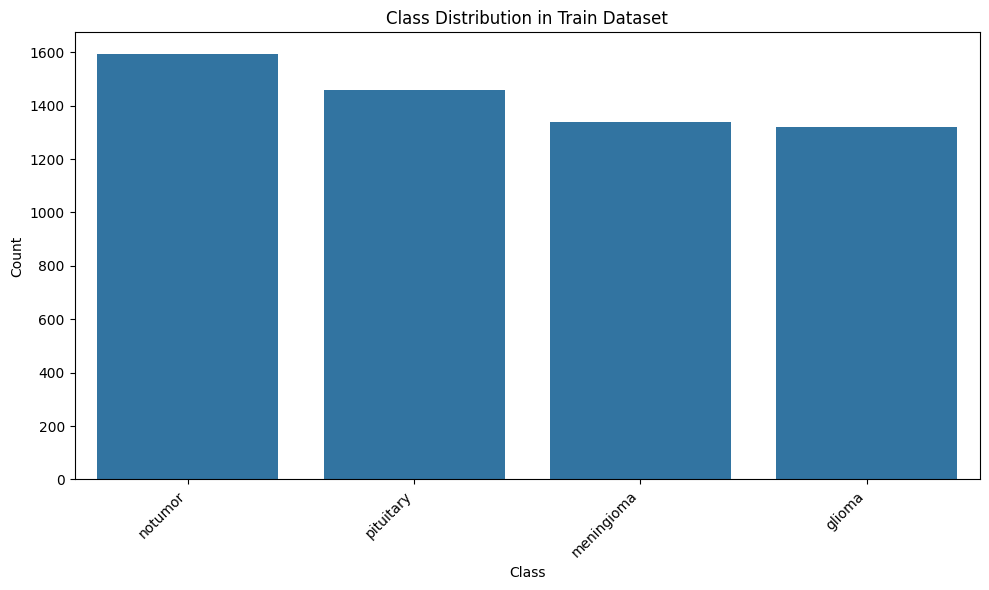

In [ ]:
plot_class_distribution(tr_df, 'Class', title='Class Distribution in Train Dataset')

## 2.2. Tải lên dữ liệu để kiểm tra

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
ts_df = test_df(path + '/Testing')

In [ ]:
val_df, ts_df = train_test_split(ts_df, test_size=0.5, stratify=ts_df['Class'], random_state=42)

In [ ]:
ts_df

,Class Path,Class
807,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
755,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
660,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
890,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1051,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
...,...,...
372,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
122,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
411,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
925,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma


In [ ]:
val_df

,Class Path,Class
537,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
734,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
470,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1169,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
996,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
...,...,...
882,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1138,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1120,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
458,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


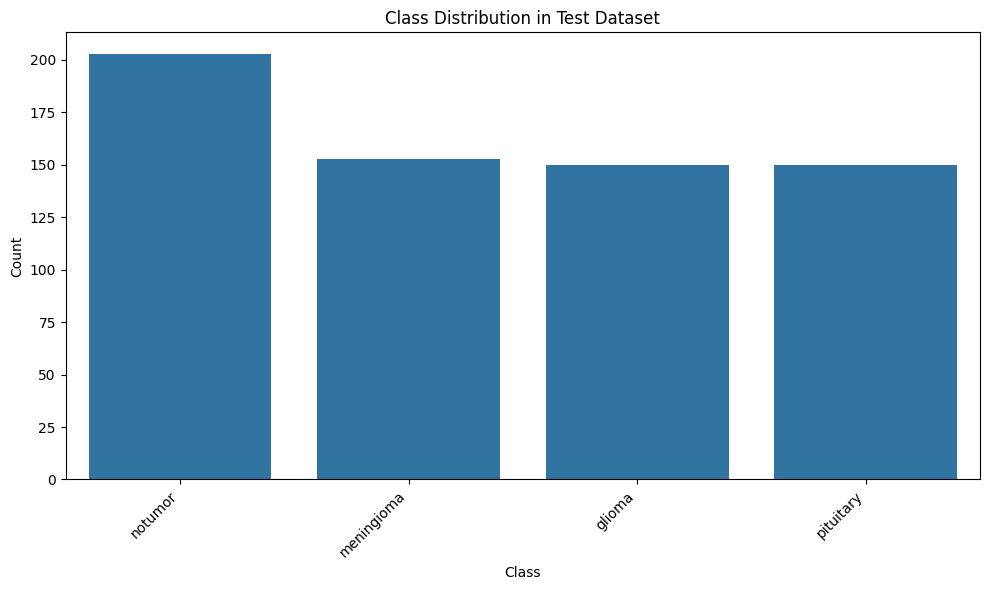

In [ ]:
plot_class_distribution(ts_df, 'Class', title='Class Distribution in Test Dataset')

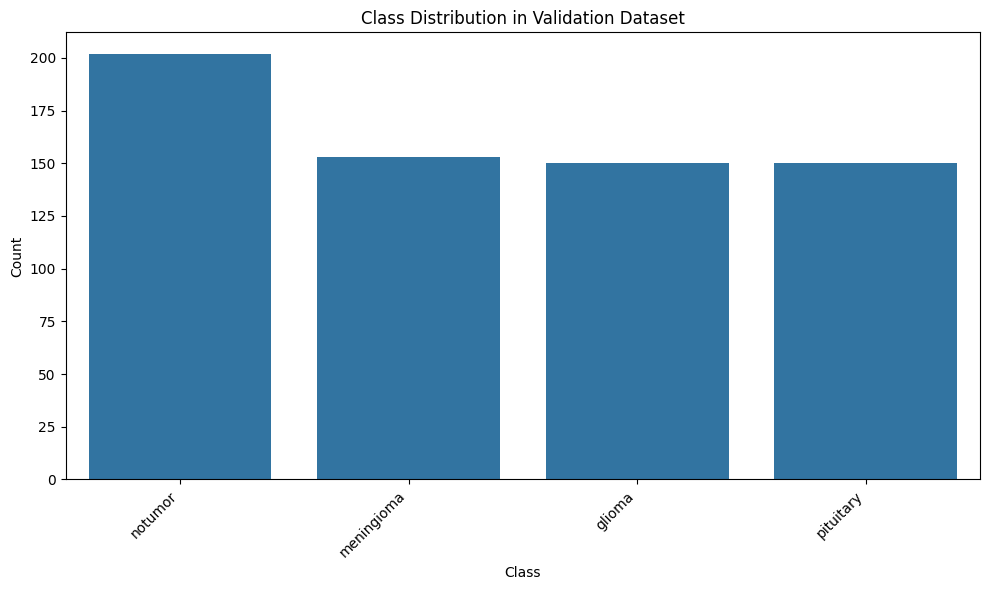

In [ ]:
plot_class_distribution(val_df, 'Class', title='Class Distribution in Validation Dataset')

## 2.3. Tiền xử lý dữ liệu

In [ ]:
batch_size = 32
img_size = (299, 299)
# img_size = (150, 150)

_gen = ImageDataGenerator( # Tiền xử lý dữ liệu để train model
    rescale=1./255,
    rotation_range=5,
    brightness_range=(0.95, 1.05),
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest')

ts_gen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

tr_gen = _gen.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col = 'Class',
    batch_size = batch_size,
    target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(
    ts_df,
    x_col='Class Path',
    y_col = 'Class',
    batch_size = batch_size,
    target_size=img_size,
    shuffle=False)

val_gen = val_datagen.flow_from_dataframe(
    ts_df,
    x_col='Class Path',
    y_col = 'Class',
    batch_size = batch_size,
    target_size=img_size,
    shuffle=True
)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4. Lấy vài ví dụ từ dữ liệu

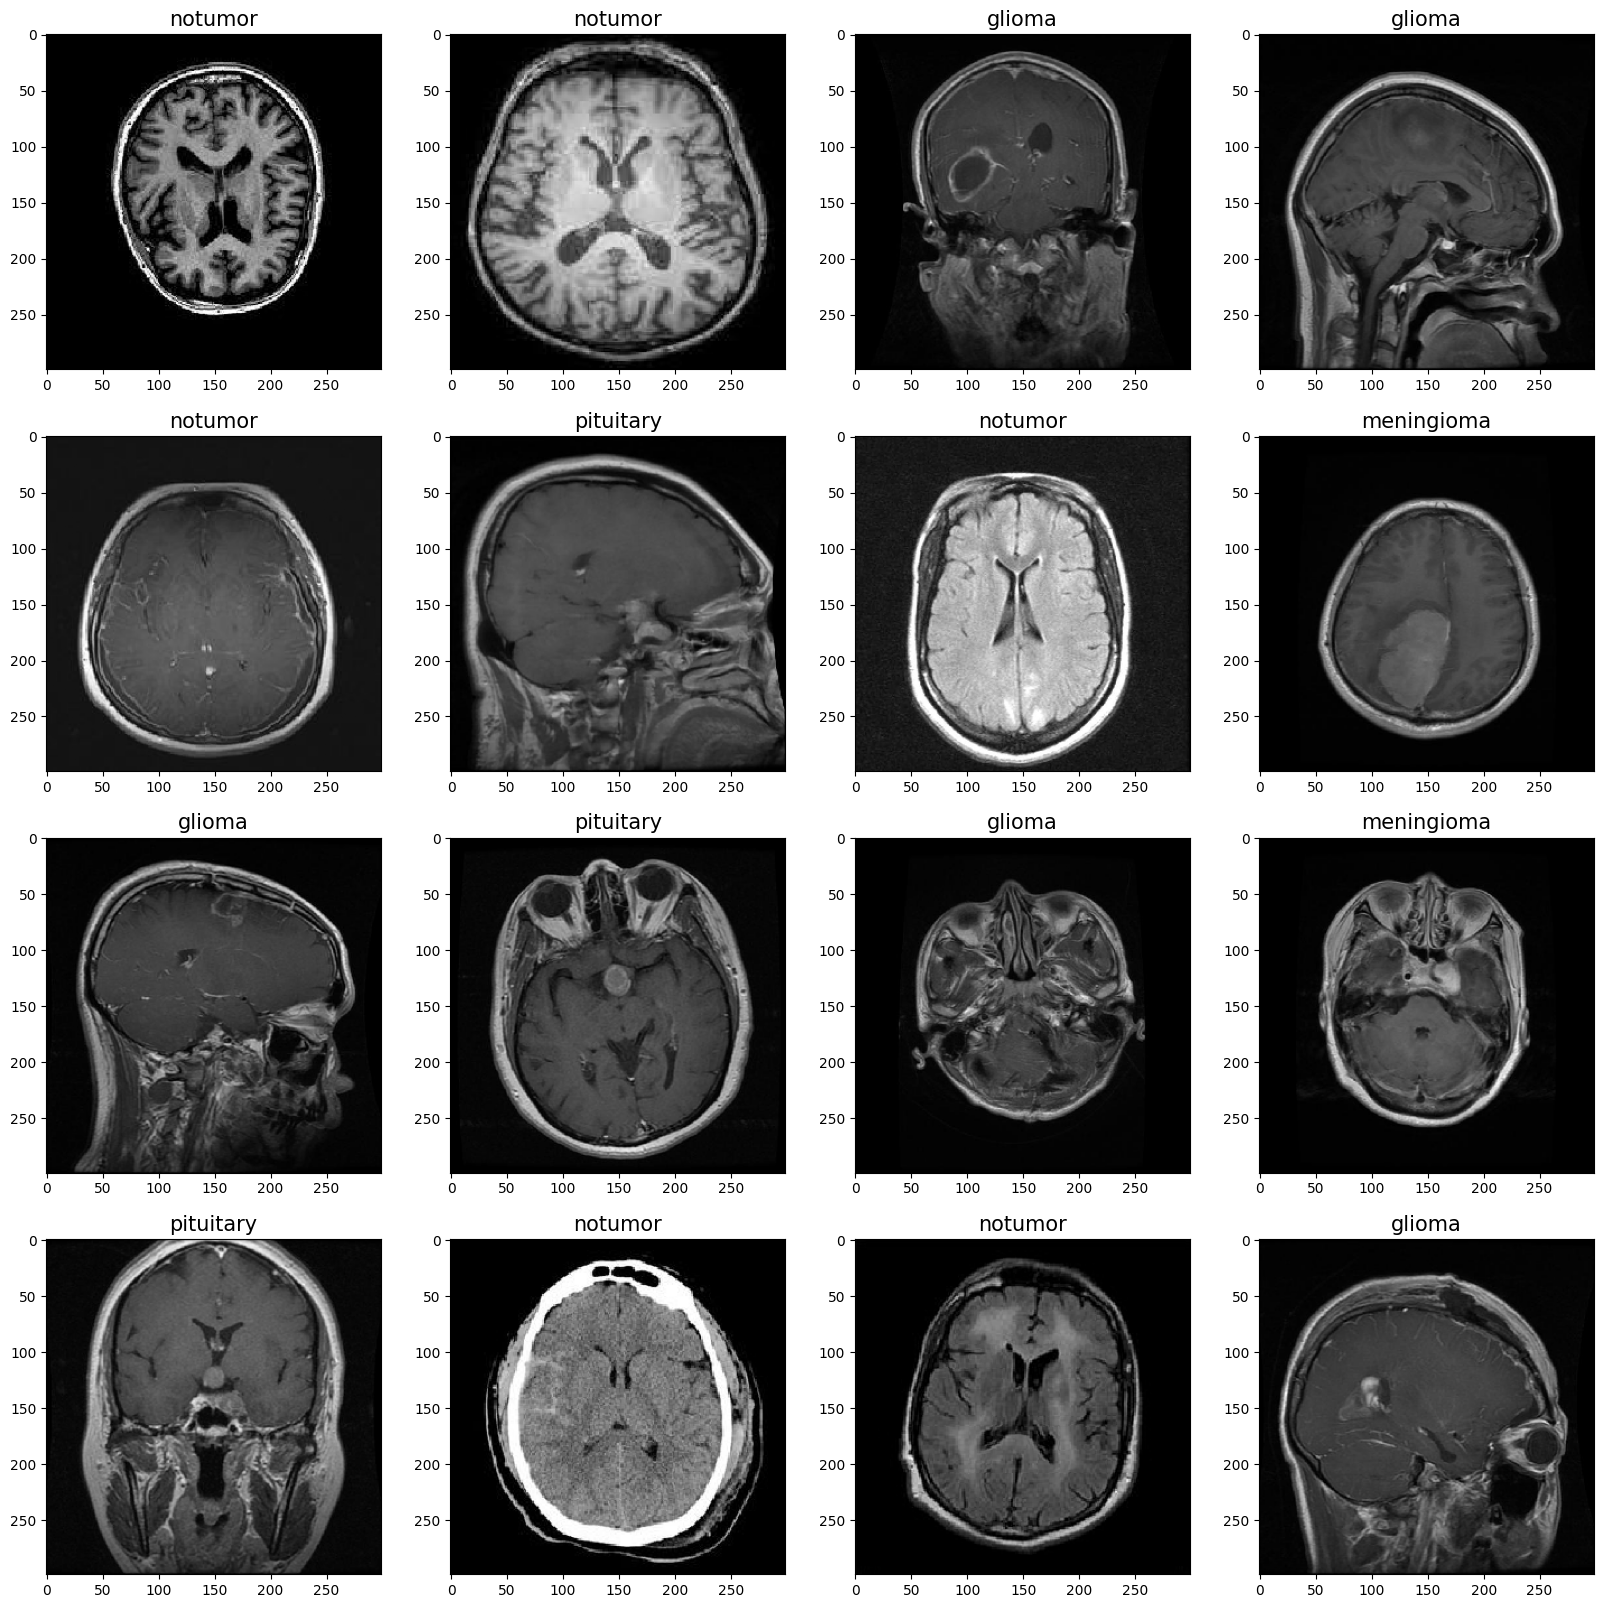

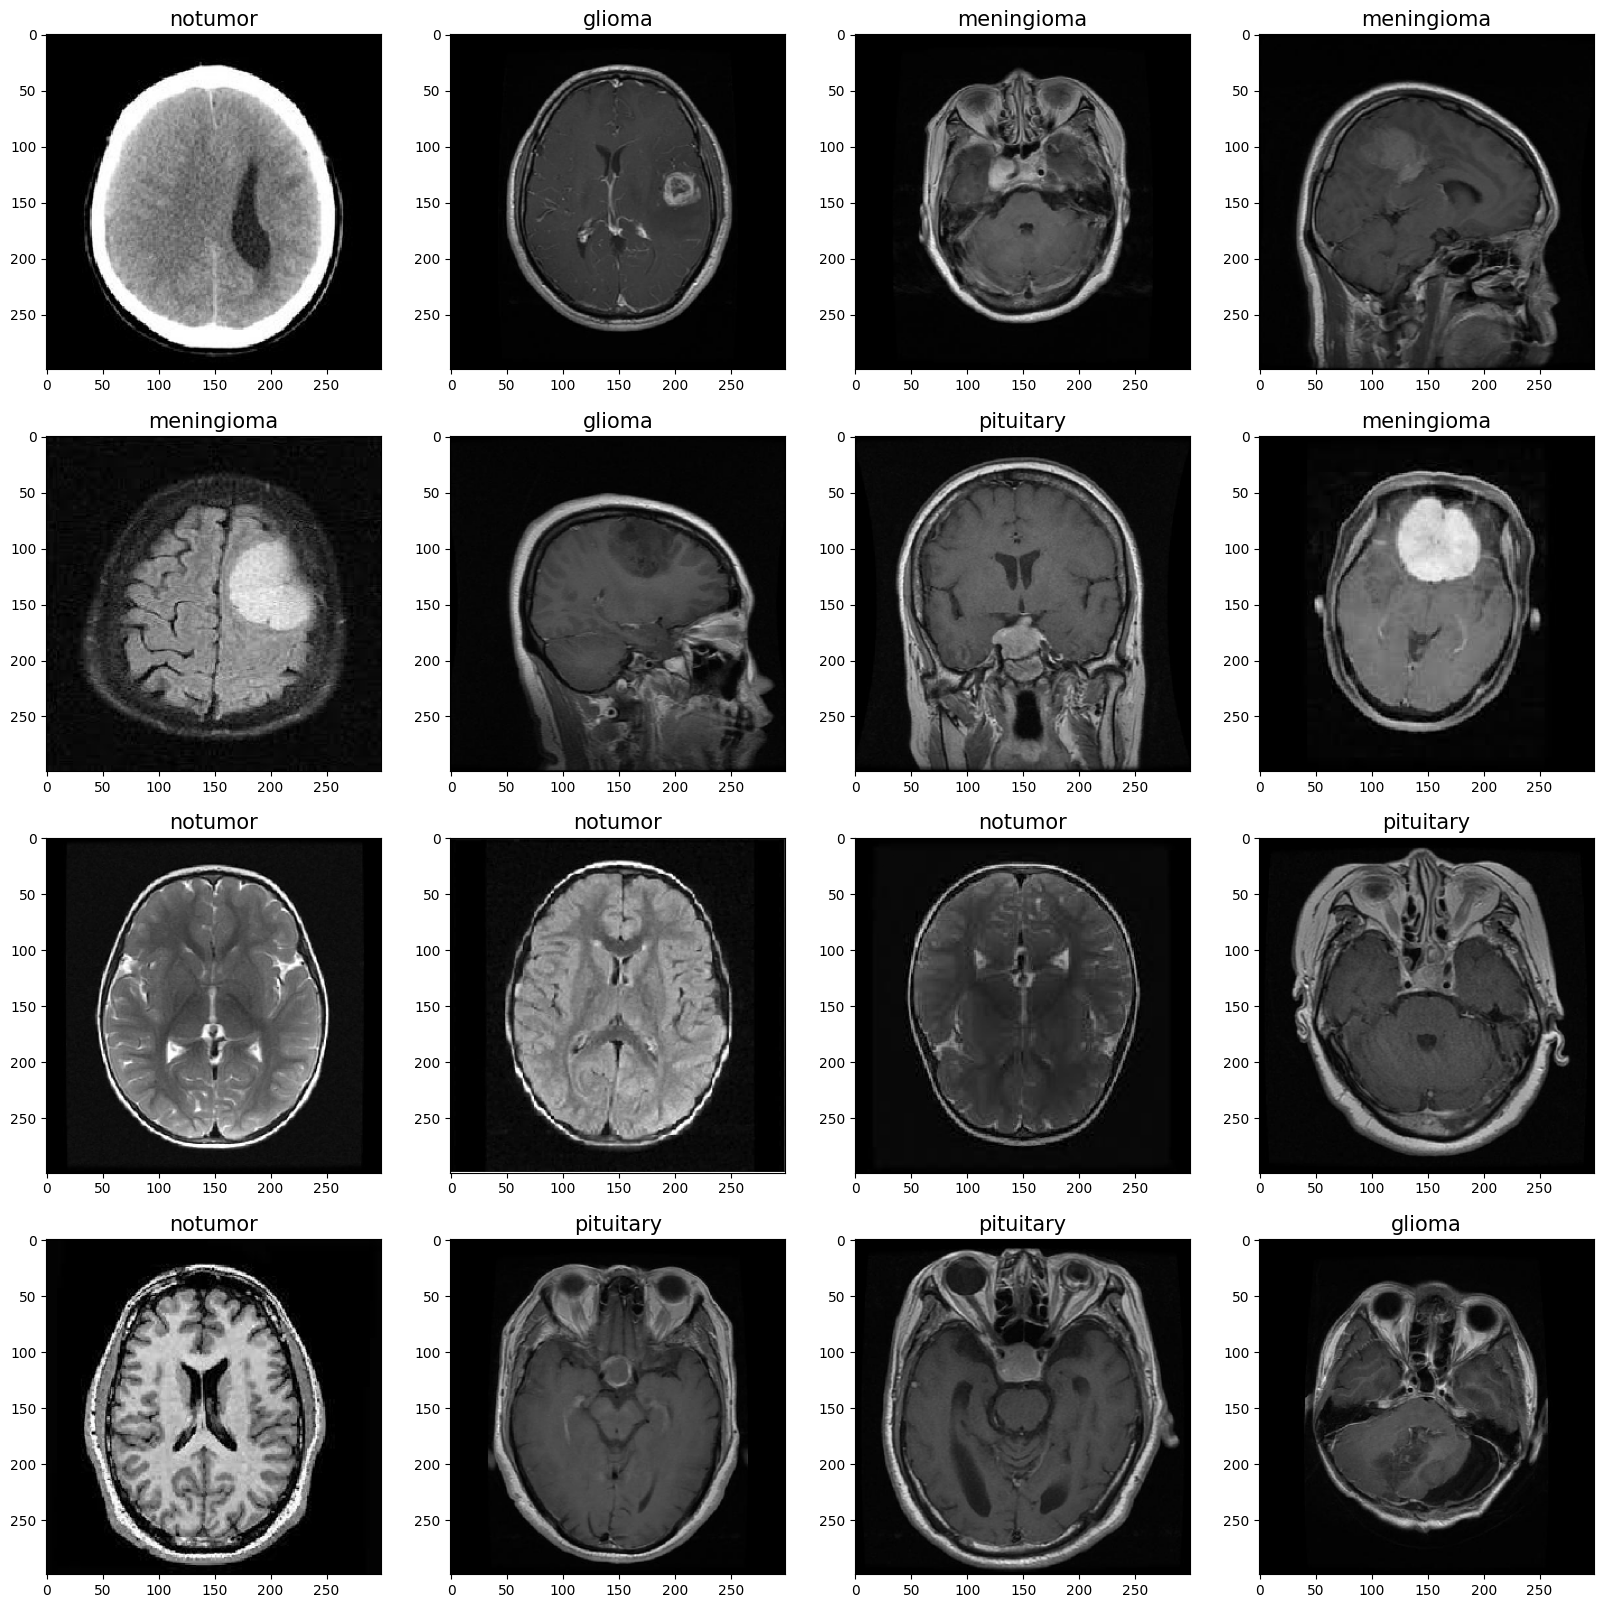

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(val_gen)

num_images = len(images)
num_cols = 4
num_rows = 4
images_per_figure = num_cols * num_rows

num_figures = int(np.ceil(num_images / images_per_figure))

for fig_num in range(num_figures):
    start_index = fig_num * images_per_figure
    end_index = min(start_index + images_per_figure, num_images)

    plt.figure(figsize=(20, 20))

    for i in range(start_index, end_index):
        plt.subplot(num_rows, num_cols, i - start_index + 1)
        plt.imshow(images[i])
        class_name = classes[np.argmax(labels[i])]
        plt.title(class_name, color='k', fontsize=15)

    plt.show()

# 3. Xây dựng model

3.1. Mô hình CNN đơn giản

In [ ]:
"""
import tensorflow as tf
from tensorflow.keras import layers, models
# Không chạy song song với model được fine tune
img_shape=(150,150,3)

# Khởi tạo mô hình
model = models.Sequential()

# Lớp convolution đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Lớp convolution thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Lớp convolution thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten và Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # chống overfitting
model.add(layers.Dense(4, activation='softmax'))  # 4 lớp: meningioma, glioma, pituitary, notumor

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()
"""

"\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\n# Không chạy song song với model được fine tune\nimg_shape=(150,150,3)\n\n# Khởi tạo mô hình\nmodel = models.Sequential()\n\n# Lớp convolution đầu tiên\nmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\n# Lớp convolution thứ hai\nmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\n# Lớp convolution thứ ba\nmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))\nmodel.add(layers.MaxPooling2D((2, 2)))\n\n# Flatten và Fully Connected Layers\nmodel.add(layers.Flatten())\nmodel.add(layers.Dense(128, activation='relu'))\nmodel.add(layers.Dropout(0.5))  # chống overfitting\nmodel.add(layers.Dense(4, activation='softmax'))  # 4 lớp: meningioma, glioma, pituitary, notumor\n\n# Biên dịch mô hình\nmodel.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accur

3.2. Mô hình sử dụng Xception

In [ ]:
img_shape=(299,299,3)

base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = "imagenet",
    input_shape = img_shape,
    pooling = 'max')

for layer in base_model.layers[-20:]: # unfreeze 20 lớp cuối
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(4, activation = 'softmax')
])

model.compile(Adamax(learning_rate = 1e-4, weight_decay = 1e-5),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

# 4. Huấn luyện

## 4.1. Huấn luyện model

In [ ]:
# early_stop = EarlyStopping(patience=2, monitor="val_loss", mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0) # nếu val_loss tiếp tục tăng 2 lần liên tiếp thì sẽ tự động dừng training, tránh trường hợp overfit
# model_lrl = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=0, verbose=True) # nếu val_loss tiếp tục tăng 2 lần liên tiếp sẽ bắt đầu làm giảm learning rate tới 80%, đã sửa patience = 0, chưa chạy lại
hist = model.fit(tr_gen,
                 epochs = 10,
                #  validation_data = ts_gen,
                  validation_data = val_gen,
                #  callbacks=[early_stop, model_lrl],
                 shuffle = True)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6833 - loss: 0.8291 - precision: 0.7339 - recall: 0.6099 - val_accuracy: 0.6829 - val_loss: 0.7867 - val_precision: 0.7209 - val_recall: 0.6616
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9271 - loss: 0.2064 - precision: 0.9361 - recall: 0.9221 - val_accuracy: 0.7485 - val_loss: 0.6822 - val_precision: 0.7742 - val_recall: 0.7317
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9632 - loss: 0.1090 - precision: 0.9667 - recall: 0.9601 - val_accuracy: 0.9192 - val_loss: 0.2352 - val_precision: 0.9257 - val_recall: 0.9116
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9776 - loss: 0.0623 - precision: 0.9799 - recall: 0.9768 - val_accuracy: 0.9726 - val_loss: 0.0978 - val_precision: 0.9755 - val_recall: 0.9710
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9833 - loss: 0.0518 - precision: 0.9840 - recall: 0.9822 - val_accuracy: 0.9787 - val_los

In [ ]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

## 4.2. Thống kê hiệu suất

In [ ]:
def plot_training_metrics(hist):
    metrics = {
        'Loss': ('loss', 'val_loss', 'Lowest Val Loss', np.argmin),
        'Accuracy': ('accuracy', 'val_accuracy', 'Highest Val Acc', np.argmax),
        'Precision': ('precision', 'val_precision', 'Highest Val Precision', np.argmax),
        'Recall': ('recall', 'val_recall', 'Highest Val Recall', np.argmax)
    }

    # Make sure all keys exist in history
    for key_set in metrics.values():
        for key in key_set[:2]:  # train_key and val_key
            if key not in hist.history:
                print(f"Key '{key}' not found in training history. Skipping related plot.")
                return

    epochs = range(1, len(hist.history['loss']) + 1)
    plt.figure(figsize=(16, 10))

    for i, (title, (train_key, val_key, label, best_fn)) in enumerate(metrics.items(), 1):
        train = hist.history[train_key]
        val = hist.history[val_key]
        idx = best_fn(val)
        best_val = val[idx]

        plt.subplot(2, 2, i)
        plt.plot(epochs, train, 'r', label=f'Training {title}')
        plt.plot(epochs, val, 'g', label=f'Validation {title}')
        plt.scatter(idx + 1, best_val, s=150, c='blue', label=label)
        plt.title(f'{title} and Validation {title}')
        plt.xlabel('Epochs')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


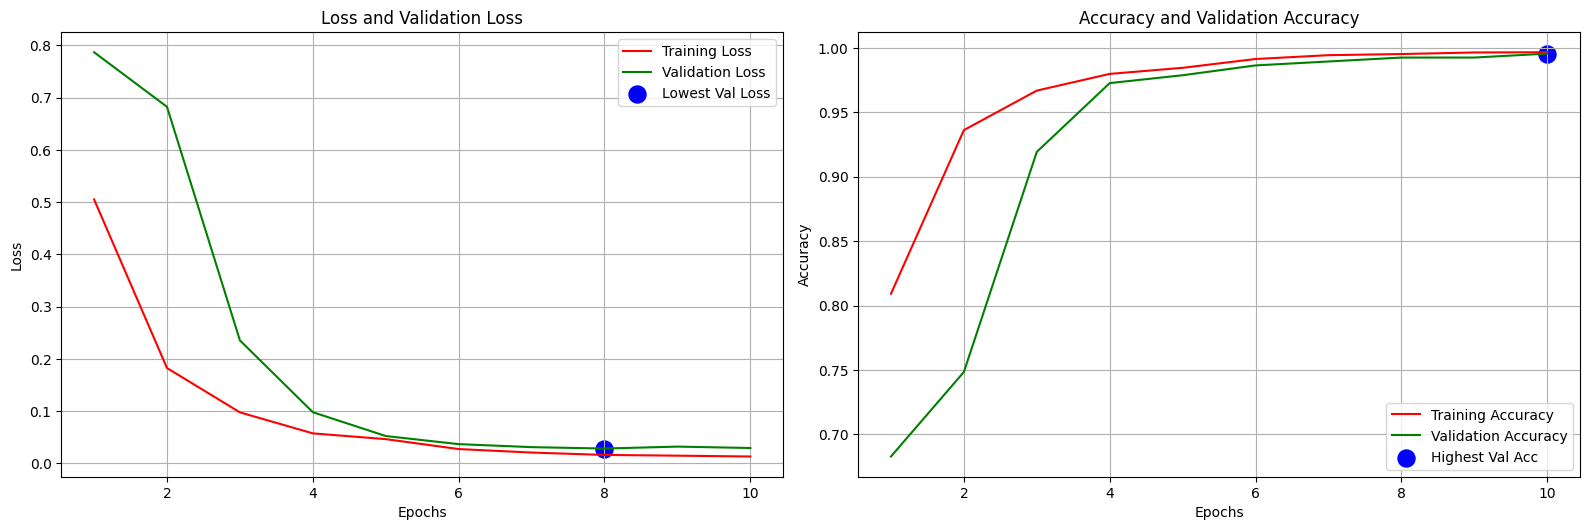

In [ ]:
plot_training_metrics(hist)

# 5. Kiểm tra và đánh giá

## 5.1. Kiểm tra

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 801ms/step - accuracy: 0.9994 - loss: 0.0011 - precision: 0.9994 - recall: 0.9994
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9969 - loss: 0.0242 - precision: 0.9969 - recall: 0.9969
Train Loss: 0.0012
Train Accuracy: 99.95%
--------------------
--------------------
Test Loss: 0.0293
Test Accuracy: 99.54%


In [ ]:
preds = model.predict(ts_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step


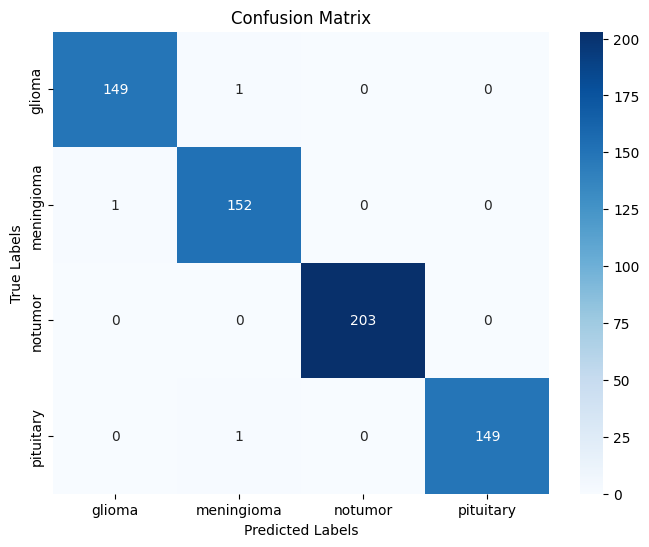

In [ ]:
true_labels = ts_gen.classes

cm = confusion_matrix(true_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(ts_gen.labels, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       1.00      0.99      1.00       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656



In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(10, 10))
    img = Image.open(img_path)
    resized_img = img.resize(img_size)
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


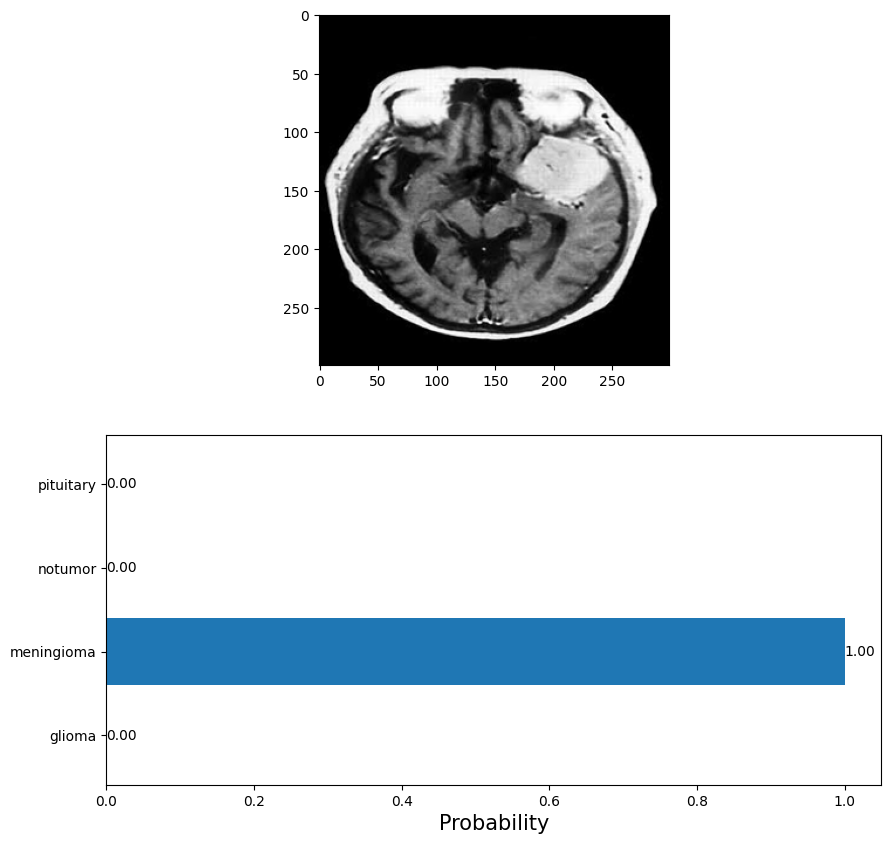

In [ ]:
predict(path + '/Testing/meningioma/Te-meTr_0005.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


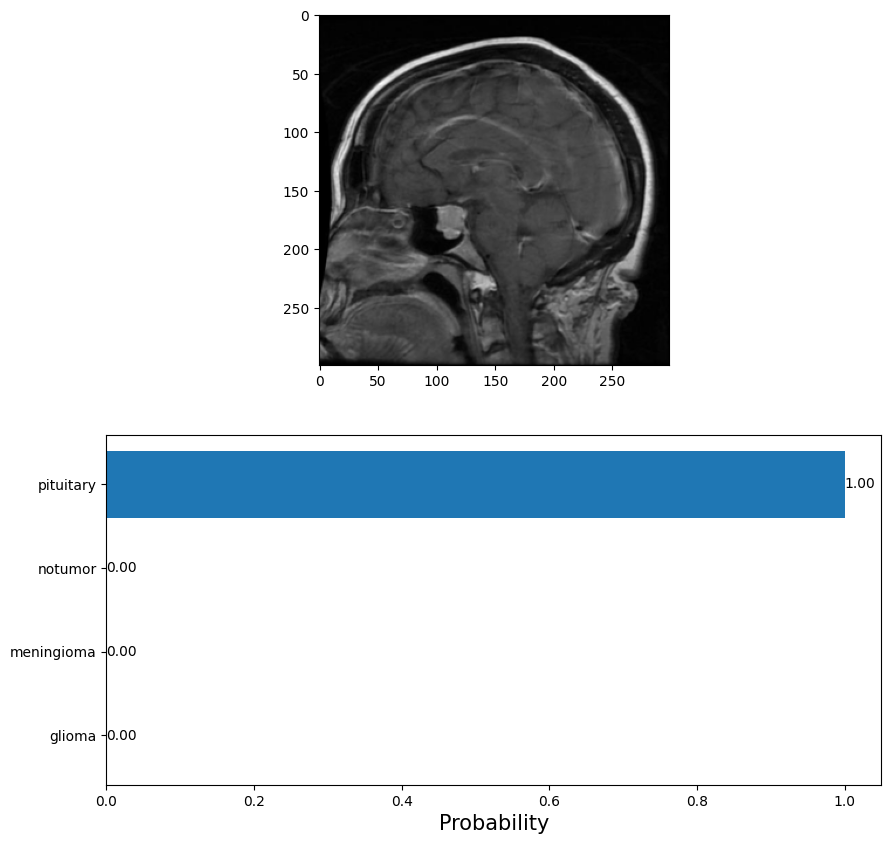

In [ ]:
predict(path + '/Testing/pituitary/Te-piTr_0005.jpg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# model.save('/content/drive/MyDrive/models/ML-AP06_SimpleCNN.h5')
model.save('/content/drive/MyDrive/models/ML-AP06_FineTuneXception.h5')

## 5.2. Đánh giá

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check if the model file exists
import os
# model_path = '/content/drive/MyDrive/models/ML-AP06_SimpleCNN.h5'
model_path = '/content/drive/MyDrive/models/ML-AP06_FineTuneXception.h5'
if os.path.exists(model_path):
  model = tf.keras.models.load_model(model_path)
else:
  print(f"Error: Model file not found at {model_path}")
  # Handle the error, e.g., train a new model or exit

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img = path + '/Testing/meningioma/Te-me_0011.jpg'
img_size = (299, 299)
# img_size = (150, 150)
# Load and preprocess the image
from PIL import Image
import numpy as np
img = Image.open(img)
img = img.resize(img_size) # Resize to match the input shape of the model
img = np.asarray(img)
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values

# Make predictions
predictions = model.predict(img)

# Get class labels from the training generator (tr_gen)
class_labels = list(tr_gen.class_indices.keys()) # Get class labels in the correct order

# Get class with highest probability
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = np.max(predictions) * 100  # Convert to percentage

# In kết quả
print("\n===== Brain Tumor Classification Result =====")
print(f"Predicted Tumor Type: {predicted_class.upper()}")
print(f"Confidence: {confidence:.2f}%")
print("=============================================\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

===== Brain Tumor Classification Result =====
Predicted Tumor Type: MENINGIOMA
Confidence: 98.62%

